<a href="https://colab.research.google.com/github/Trimad/10PRINT_Image_Filter/blob/master/ESSDN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Extremely Simple Stable Diffusion Notebook**

For the ones that aren't tech savvy.

There will be input boxes where you have to input information.

In order to view the images, you need to navegate through the folders and go to forks/stable-diffusion-main/outputs/txt2img-samples/samples or img2img-samples/samples if you are doing img2img.

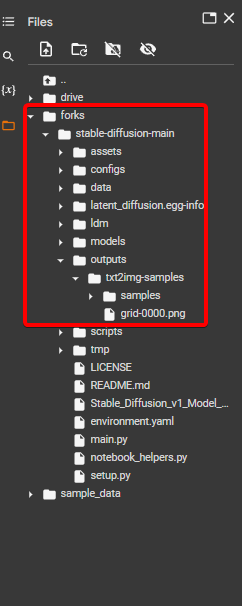

Double click on the files to show them on the right side.

In [1]:
#@title
#@markdown Press the play button to start.
import subprocess
import sys
import platform
def instpkg(packagename):
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', packagename])
response = input("From this point forward, we are going to install packages/verify packages, do you agree? (Y/N): ")
if response == "N":
    exit()
instpkg("requests")
instpkg("pyuac")
import requests
import os
import zipfile
import shutil

def download_file(url, filename):
    link = url
    file_name = filename
    with open(file_name, "wb") as f:
        print("Downloading %s" % file_name)
        response = requests.get(link, stream=True)
        total_length = response.headers.get('content-length')

        if total_length is None: # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in response.iter_content(chunk_size=4096):
                dl += len(data)
                f.write(data)
                done = int(50 * dl / total_length)
                sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )    
                sys.stdout.flush()

def unzip(file_to_unzip, path_to_extract):
    with zipfile.ZipFile(file_to_unzip, "r") as zip_ref:
        zip_ref.extractall(path_to_extract)

print("It is Highly recommended to use Python 3.7.9+")
print("Many dependencies such as OpenCV only work on specific versions that are only available for Python 3.7.")
print("Current Python Version: " + platform.python_version())
print("You can press Control+C to exit the program. There will be no more annoncements about this.")
input("Press Enter to Continue...")

print("A new folder is going to be created to store everything needed. Please check that this directory is the one you want.")
print("Current working directory:" + os.getcwd())
response = input("Continue? (Y/N): ")
if response == "N":
    exit()

print("Creating /forks")
os.mkdir("forks")
os.chdir("forks")
print("Downloading Official Repository. CompVis/stable-diffusion")
download_file("https://github.com/CompVis/stable-diffusion/archive/refs/heads/main.zip", "main.zip")
print("Unzipping File")
unzip("main.zip", "./")
print("File unzipped, removing main.zip")
os.remove("main.zip")
os.chdir("stable-diffusion-main")
print("Creating folders")
os.mkdir("scripts/configs")
os.mkdir("scripts/configs/stable-diffusion")
print("Copying configuration file v1-inference.yaml")
shutil.copy("configs/stable-diffusion/v1-inference.yaml", "scripts/configs/stable-diffusion/v1-inference.yaml")
#Please check spelling
print("Downloading and Instaling dependencies...")
instpkg("albumentations==0.4.3")
instpkg("opencv-python==4.1.2.30")
instpkg("pudb==2019.2")
instpkg("imageio==2.9.0")
instpkg("imageio-ffmpeg==0.4.2")
#instpkg("pytorch-lightning==1.4.2")
instpkg("pytorch-lightning")
instpkg("omegaconf==2.1.1")
instpkg("test-tube>=0.7.5")
instpkg("streamlit>=0.73.1")
instpkg("einops==0.3.0")
instpkg("torch-fidelity==0.3.0")
instpkg("transformers==4.19.2")
instpkg("kornia")

print("Downloading and installing github dependencies")
os.mkdir("tmp")
download_file("https://github.com/CompVis/taming-transformers/archive/refs/heads/master.zip", "tmp/taming-transformers.zip")
download_file("https://github.com/openai/CLIP/archive/refs/heads/main.zip", "tmp/CLIP.zip")
unzip("tmp/taming-transformers.zip", "tmp")
unzip("tmp/CLIP.zip", "tmp")
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-e', 'tmp/taming-transformers-master'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-e', 'tmp/CLIP-main'])

print("Installing project dependencies")
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-e', '.'])

print("Downloading weights")
print("Be patient as this might take a while. If this crashes here, look for another direct download and replace the link in the script. Delete the forks folder and restart the process (dependencies will stay)")
THIS_IS_THE_DOWNLOAD_LINK = input("input your download link (mediafire doesn't works btw): ")
download_file(THIS_IS_THE_DOWNLOAD_LINK, "model.ckpt")
print("Download Finished, moving weights.")
os.mkdir("models/ldm/stable-diffusion-v1")
os.replace("model.ckpt", "models/ldm/stable-diffusion-v1/model.ckpt")
!python -m pip install taming-transformers
print("Part 1 Installation finished")

From this point forward, we are going to install packages/verify packages, do you agree? (Y/N): Y
It is Highly recommended to use Python 3.7.9+
Many dependencies such as OpenCV only work on specific versions that are only available for Python 3.7.
Current Python Version: 3.7.13
You can press Control+C to exit the program. There will be no more annoncements about this.
Press Enter to Continue...
A new folder is going to be created to store everything needed. Please check that this directory is the one you want.
Current working directory:/content
Continue? (Y/N): Y
Creating /forks
Unzipping File
File unzipped, removing main.zip
Creating folders
Copying configuration file v1-inference.yaml
Installing project dependencies
Be patient as this might take a while. If this crashes here, look for another direct download and replace the link in the script. Delete the forks folder and restart the process (dependencies will stay)
input your download link (mediafire doesn't works btw): https://drink

In [3]:
#@title
#@markdown Once the first cell has finished. Press this play button.
import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm.notebook import tqdm, trange
from itertools import islice
from einops import rearrange
from torchvision.utils import make_grid
import time
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import contextmanager, nullcontext
import sys
import os

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

os.chdir("/content/forks/stable-diffusion-main")

def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())


def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cuda:0")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

class Config():
    def __init__(self):        
        self.outdir = 'outputs/txt2img-samples'
        self.ddim_steps = 50
        self.plms = False

        self.init_img = None
        
        self.laion400m = False
        self.seed = 42
        self.config = 'configs/stable-diffusion/v1-inference.yaml'
        self.ckpt = 'models/ldm/stable-diffusion-v1/model.ckpt'
        self.precision = 'autocast'
        self.n_rows = 0
        self.fixed_code = True
        self.from_file = False
        self.C = 4
        self.H = 512
        self.W = 512
        self.f = 8
        self.n_samples = 1
        self.n_iter = 1
        self.scale = 7.5
        self.ddim_eta = 0.0
        self.skip_save = False
        self.skip_grid = False

opt = Config()

if opt.laion400m:
        print("Falling back to LAION 400M model...")
        opt.config = "configs/latent-diffusion/txt2img-1p4B-eval.yaml"
        opt.ckpt = "models/ldm/text2img-large/model.ckpt"
        opt.outdir = "outputs/txt2img-samples-laion400m"

seed_everything(opt.seed)

config = OmegaConf.load(f"{opt.config}")
model = load_model_from_config(config, f"{opt.ckpt}")
model = model.half()

def txt2img(opt, model):
    device = 'cuda'
    if opt.plms:
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)
    os.makedirs(opt.outdir, exist_ok=True)
    outpath = opt.outdir
    batch_size = opt.n_samples
    n_rows = opt.n_rows if opt.n_rows > 0 else batch_size
    images = []
    if not opt.from_file:

        assert opt.prompt is not None
        data = [batch_size * [opt.prompt]]

    else:
        print(f"reading prompts from {opt.from_file}")
        with open(opt.from_file, "r") as f:
            data = f.read().splitlines()
            data = list(chunk(data, batch_size))

    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    base_count = len(os.listdir(sample_path))
    grid_count = len(os.listdir(outpath)) - 1

    start_code = None
    if opt.fixed_code:
        start_code = torch.randn([opt.n_samples, opt.C, opt.H // opt.f, opt.W // opt.f], device=device)

    precision_scope = autocast if opt.precision=="autocast" else nullcontext
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                #tic = time.time()
                all_samples = list()
                for n in trange(opt.n_iter, desc="Sampling"):
                    for prompts in tqdm(data, desc="data"):
                        uc = None
                        if opt.scale != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)
                        c = model.get_learned_conditioning(prompts)
                        shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
                        samples_ddim, _ = sampler.sample(S=opt.ddim_steps,
                                                         conditioning=c,
                                                         batch_size=opt.n_samples,
                                                         shape=shape,
                                                         verbose=False,
                                                         unconditional_guidance_scale=opt.scale,
                                                         unconditional_conditioning=uc,
                                                         eta=opt.ddim_eta,
                                                         x_T=start_code)

                        x_samples_ddim = model.decode_first_stage(samples_ddim)
                        x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)

                        if not opt.skip_save:
                            for x_sample in x_samples_ddim:
                                x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                                images +=[Image.fromarray(x_sample.astype(np.uint8))]
                                images[-1].save(
                                    os.path.join(sample_path, f"{base_count:05}.png"))
                                base_count += 1

                        if not opt.skip_grid:
                            all_samples.append(x_samples_ddim)

                if not opt.skip_grid:
                    # additionally, save as grid
                    grid = torch.stack(all_samples, 0)
                    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
                    grid = make_grid(grid, nrow=n_rows)

                    # to image
                    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
                    image = Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'grid-{grid_count:04}.png'))
                    Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'grid-{grid_count:04}.png'))
                    grid_count += 1
                print(f'Your images are here {outpath}')
    return images


print("Everything is ready!")
print("self.n_samples set to 1, you can change it in line 67")
print("Please select one of the options:")
while True:
    print("[1] txt2img")
    print("[2] img2img")
    selected = input("type a number:")
    if selected == "1":
        opt = Config()
        opt.plms = True
        # Uncomment to modify parameters
        #opt.ddim_steps = 70
        #opt.scale = 10.0
        #opt.n_iter = 1
        #opt.n_samples = 1
        #opt.seed = 1234; seed_everything(opt.seed)
        opt.prompt = input("Type the desired prompt: ")
        images = txt2img(opt, model)
    if selected == "2":
        import PIL
        from einops import repeat
        def load_img(path):
            image = Image.open(path).convert("RGB")
            w, h = image.size
            print(f"loaded input image of size ({w}, {h}) from {path}")
            w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
            image = image.resize((w, h), resample=PIL.Image.LANCZOS)
            image = np.array(image).astype(np.float32) / 255.0
            image = image[None].transpose(0, 3, 1, 2)
            image = torch.from_numpy(image)
            return 2.*image - 1.

        def img2img(opt, model):
            device = "cuda"
            if opt.plms:
                raise NotImplementedError("PLMS sampler not (yet) supported")
                sampler = PLMSSampler(model)
            else:
                sampler = DDIMSampler(model)
            images = []
            os.makedirs(opt.outdir, exist_ok=True)
            outpath = opt.outdir

            batch_size = opt.n_samples
            n_rows = opt.n_rows if opt.n_rows > 0 else batch_size
            if not opt.from_file:
                prompt = opt.prompt
                assert prompt is not None
                data = [batch_size * [prompt]]

            else:
                print(f"reading prompts from {opt.from_file}")
                with open(opt.from_file, "r") as f:
                    data = f.read().splitlines()
                    data = list(chunk(data, batch_size))

            sample_path = os.path.join(outpath, "samples")
            os.makedirs(sample_path, exist_ok=True)
            base_count = len(os.listdir(sample_path))
            grid_count = len(os.listdir(outpath)) - 1

            assert os.path.isfile(opt.init_img)
            init_image = load_img(opt.init_img).to(device).type(model.dtype)
            init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
            init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space

            sampler.make_schedule(ddim_num_steps=opt.ddim_steps, ddim_eta=opt.ddim_eta, verbose=False)

            assert 0. <= opt.strength <= 1., 'can only work with strength in [0.0, 1.0]'
            t_enc = int(opt.strength * opt.ddim_steps)
            print(f"target t_enc is {t_enc} steps")

            precision_scope = autocast if opt.precision == "autocast" else nullcontext
            with torch.no_grad():
                with precision_scope("cuda"):
                    with model.ema_scope():
                        tic = time.time()
                        all_samples = list()
                        for n in trange(opt.n_iter, desc="Sampling"):
                            for prompts in tqdm(data, desc="data"):
                                uc = None
                                if opt.scale != 1.0:
                                    uc = model.get_learned_conditioning(batch_size * [""])
                                if isinstance(prompts, tuple):
                                    prompts = list(prompts)
                                c = model.get_learned_conditioning(prompts)

                                # encode (scaled latent)
                                z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
                                # decode it
                                samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=opt.scale,
                                                        unconditional_conditioning=uc,)

                                x_samples = model.decode_first_stage(samples)
                                x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                                if not opt.skip_save:
                                    for x_sample in x_samples:
                                        x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                                        images += [Image.fromarray(x_sample.astype(np.uint8))]
                                        images[-1].save(
                                            os.path.join(sample_path, f"{base_count:05}.png"))
                                        base_count += 1
                                all_samples.append(x_samples)

                        if not opt.skip_grid:
                            # additionally, save as grid
                            grid = torch.stack(all_samples, 0)
                            grid = rearrange(grid, 'n b c h w -> (n b) c h w')
                            grid = make_grid(grid, nrow=n_rows)

                            # to image
                            grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
                            Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'grid-{grid_count:04}.png'))
                            grid_count += 1

                        toc = time.time()

            print(f"Your samples are ready and waiting for you here: \n{outpath} \n"
                f" \nEnjoy.")
            return images

        opt = Config()
        opt.outdir = "outputs/img2img-samples"
        opt.strength = input("Strength: ")
        # Uncomment to modify parameters
        #opt.scale = 10.0
        #opt.n_iter = 1
        #opt.n_samples = 1
        #opt.seed = 1234; seed_everything(opt.seed)
        opt.prompt = input("Prompt: ")
        opt.init_img = input("Path to Input Image:") # You might want to resize your image (because of odd dimensions?)
        images = img2img(opt, model)


INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Loading model from models/ldm/stable-diffusion-v1/model.ckpt
Global Step: 440000


ModuleNotFoundError: ignored